In [1]:
import pickle

def load(path):
    with open(path, 'rb') as fp:
        params = pickle.load(fp)
    return params

gnn_params = load('/home/lrambelli/patternreco/params_gnn.pkl')

In [2]:
import numpy as np
import torch
import jax.numpy as jnp
import jraph
import jax.random as jrandom
import jax.tree_util as tree
import jax
import haiku as hk
from typing import Any, Callable, Dict, List, Optional, Tuple

## functions for graph creation ##

#function that compute the node number (hit number) for each graph (event) in the batch
def get_node_number(arrays, batch_size):
    node_numbers = []
    x = arrays[0]
    
    for i in range(batch_size):
        
        xx = x[i]
        node_numbers.append([xx.shape[0]])
    max_value = np.max(node_numbers)
    #max_value = 384
    
    return node_numbers, max_value

#function that returns the n_nodes and n_edges vectors required for defining the GraphTuple
#n_nodes vector is like ([a],[b],[c]) with a,b,c nodes numbers for each graph in the batch
#n_edges vector is like ([a**2], [b**2], [c**2]) where each element is the number of edges for the graph (fully connected)

def get_nodes_edges_per_event(arrays, batch_size):
    data_array = get_node_number(arrays, batch_size)[0]

    hits_per_event = data_array
    edges_per_event = [[nhits[0]**2] for nhits in data_array]
    return hits_per_event, edges_per_event


#function that creates for each graoh in the batch the vectors defining senders and receivers
#explicitly batched graph is used so all the vectors are padded to the dimension of the bigger one 

def create_senders_receivers(arrays, batch_size):
    #nhits = get_nodes_edges_per_event(arrays, batch_size)[0]
    nhits = get_nodes_edges_per_event(arrays, batch_size)[0]
    senders = []
    receivers = []
    for nhit in nhits:
        n = nhit[0]
        s = torch.arange(n).repeat(n).tolist()
        r = torch.repeat_interleave(torch.arange(n), n).tolist()
        
        senders.append(s)
        receivers.append(r)

    padded_senders = []
    padded_receivers = []
    #max_value = 384
    max_value = get_node_number(arrays, batch_size)[1]

    for sender in senders:
        pad_s = sender + [-1] * (max_value**2 - len(sender))
        padded_senders.append(pad_s)

    for receiver in receivers:
        pad_r = receiver + [-1] * (max_value**2 - len(receiver))
        padded_receivers.append(pad_r)

    return padded_senders, padded_receivers


#function that decorates the target nodes with only the particle id (muon == -13.)
def decorate_nodes_truth(arrays, batch_size):
    nodes = []
    #max_value = 384
    max_value = get_node_number(arrays, batch_size)[1]    
    
    for i in range (0, batch_size):        
        id = np.asarray(arrays[3][i])
        id = jnp.where(jnp.absolute(id) == 13, 1, 0) #for bce

        padded_id =  jnp.pad(id, (0, max_value - len(id)), mode='constant')
        node_features = jnp.stack((padded_id), axis=-1) 
        nodes.append(node_features)

    return nodes

#function that decorates the input nodes with (y,z) coordinates
def decorate_nodes(arrays,batch_size):
    nodes = []
    max_value = get_node_number(arrays, batch_size)[1]   
    #max_value = 384 
    for i in range (0, batch_size):
        y = np.asarray(arrays[1][i])
        z = np.asarray(arrays[2][i])
                   
        pad_y =  jnp.pad(y, (0, max_value - len(y)), mode='constant')
        pad_z =  jnp.pad(z, (0, max_value - len(z)), mode='constant')
      
        padded_y = jnp.where(pad_y!=0, pad_y, 5)
        padded_z = jnp.where(pad_y!=0, pad_z, 5)

        node_features = jnp.stack((padded_y,padded_z), axis=-1)
        nodes.append(node_features)

    return nodes

def GetGraphs(arrays: np.ndarray, batch_size : int) -> jraph.GraphsTuple:
    graph = jraph.GraphsTuple(
        n_node=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[0]), 
        n_edge=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[1]), 
        nodes=jnp.array(decorate_nodes(arrays, batch_size)), 
        edges=None, 
        globals=None,  
        senders=jnp.array(create_senders_receivers(arrays, batch_size)[0]), 
        receivers=jnp.array(create_senders_receivers(arrays, batch_size)[1]))
    
    graph_truth = jraph.GraphsTuple(
        n_node=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[0]), 
        n_edge=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[1]), 
        nodes=jnp.array(decorate_nodes_truth(arrays, batch_size)), 
        edges=None, 
        globals=None,  
        senders=jnp.array(create_senders_receivers(arrays, batch_size)[0]), 
        receivers=jnp.array(create_senders_receivers(arrays, batch_size)[1]))
    
    return (graph, graph_truth)

## network definition ##

def add_self_edges_fn(receivers: jnp.ndarray, senders: jnp.ndarray,
                      total_num_nodes: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Adds self edges. Assumes self edges are not in the graph yet."""
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  return receivers, senders

#################
# GAT implementation adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L442.
def GAT(attention_query_fn: Callable,
        attention_logit_fn: Callable,
        node_update_fn: Optional[Callable] = None,
        add_self_edges: bool = True) -> Callable:
  
  # pylint: disable=g-long-lambda
  if node_update_fn is None:
    # By default, apply the leaky relu and then concatenate the heads on the
    # feature axis.
    node_update_fn = lambda x: jnp.reshape(
        jax.nn.leaky_relu(x), (x.shape[0], -1))

  def _ApplyGAT(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Attention layer."""
    nodes, edges, receivers, senders, _, _, _ = graph
    # Equivalent to the sum of n_node, but statically known.
    try:
      sum_n_node = nodes.shape[0]
    except IndexError:
      raise IndexError('GAT requires node features')

    # Pass nodes through the attention query function to transform
    # node features, e.g. with an MLP.
    nodes = attention_query_fn(nodes)

    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      receivers, senders = add_self_edges_fn(receivers, senders,
                                             total_num_nodes)

    # We compute the softmax logits using a function that takes the
    # embedded sender and receiver attributes.
    sent_attributes = nodes[senders]
    received_attributes = nodes[receivers]
    att_softmax_logits = attention_logit_fn(sent_attributes,
                                            received_attributes, edges)

    # Compute the attention softmax weights on the entire tree.
    att_weights = jraph.segment_softmax(
        att_softmax_logits, segment_ids=receivers, num_segments=sum_n_node)

    # Apply attention weights.
    messages = sent_attributes * att_weights
    # Aggregate messages to nodes.
    nodes = jax.ops.segment_sum(messages, receivers, num_segments=sum_n_node)

    # Apply an update function to the aggregated messages.
    nodes = node_update_fn(nodes)

    return graph._replace(nodes=nodes)

  # pylint: enable=g-long-lambda
  return _ApplyGAT

def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:

  def _attention_query_fn1(node_features):
        return hk.nets.MLP([4, 8, 16, 32, 64, 128, 256, 512,512, 1024])(node_features)
  
  def _attention_logit_fn1(senders, receivers, edges):
        del edges
        feat = jnp.concatenate((senders, receivers), axis=-1)
        return hk.nets.MLP([1024])(jax.nn.leaky_relu(hk.nets.MLP([1024, 512, 256, 256, 128, 128])(feat)))

  gn = GAT(
      attention_query_fn=_attention_query_fn1,

      attention_logit_fn=_attention_logit_fn1,
      node_update_fn=hk.nets.MLP([512, 256, 256, 128, 128]),
      add_self_edges=True)
  graph = gn(graph)

  def _attention_query_fn2(node_features):
        return hk.nets.MLP([128, 256, 512, 1024])(node_features)
  
  def _attention_logit_fn2(senders, receivers, edges):
        del edges
        feat = jnp.concatenate((senders, receivers), axis=-1)
        return hk.nets.MLP([128, 64, 32, 16, 8, 4, 2, 1])(jax.nn.leaky_relu(hk.nets.MLP([1024, 512, 256, 256, 128, 128])(feat)))


  gn = GAT(
      attention_query_fn=_attention_query_fn2,

      attention_logit_fn=_attention_logit_fn2,
      node_update_fn=hk.nets.MLP([1024, 512, 256, 128, 64, 32, 32, 16, 8, 4, 2, 1]),
      add_self_edges=True)
  graph = gn(graph)
 
  return graph


In [3]:
start_training = 0
end_training = 5
batch_size = 1

arrayss = np.load('/home/lrambelli/patternreco/arrays_layer_nhit.npy', allow_pickle = True)
X_nhit = arrayss[0]  #96493
Y_nhit = arrayss[1]*1e2
Z_nhit = arrayss[2]
ID_nhit = arrayss[3]

arrays_training = np.asarray((X_nhit[start_training:end_training], Y_nhit[start_training:end_training], Z_nhit[start_training:end_training], ID_nhit[start_training:end_training]))

In [4]:
def func(par, X, Y):
    A, D, theta = par
    P = A * (X**2 + Y**2) + jnp.sqrt(jnp.absolute(1 + 4*A*D)) * (X * jnp.cos(theta) + Y * jnp.sin(theta)) + D
    return 2*P/(1+jnp.sqrt(1+4*A*P))

def final_params(r):
  A3 = r[0]
  D3 = r[1]
  theta3 = r[2]

  B3 = jnp.sqrt(jnp.absolute(1+4*A3*D3))*jnp.cos(theta3)
  C3 = jnp.sqrt(jnp.absolute(1+4*A3*D3))*jnp.sin(theta3)

  fitted_xcenter = -B3/(2*A3)
  fitted_ycenter = -C3/(2*A3)
  fitted_radius = 1/(2*jnp.abs(A3))
  return fitted_xcenter, fitted_ycenter, fitted_radius

def plot_circle(center_x, center_y, radius):
    theta = np.linspace(0, 2*np.pi, 100)
    x = center_x + radius * np.cos(theta)
    y = center_y + radius * np.sin(theta)
    return x, y

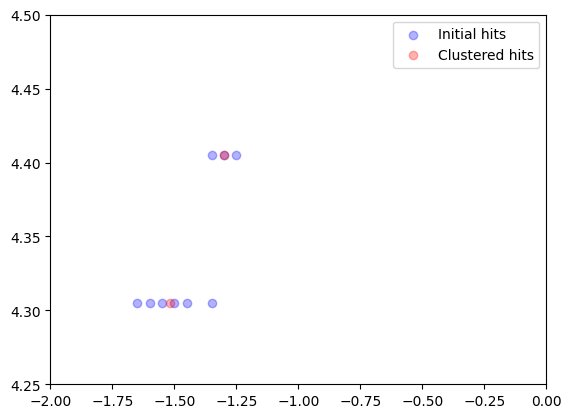

fit time:  3.7009432315826416
2.9418922969484895 -5.204164375480208 10.502805305404758


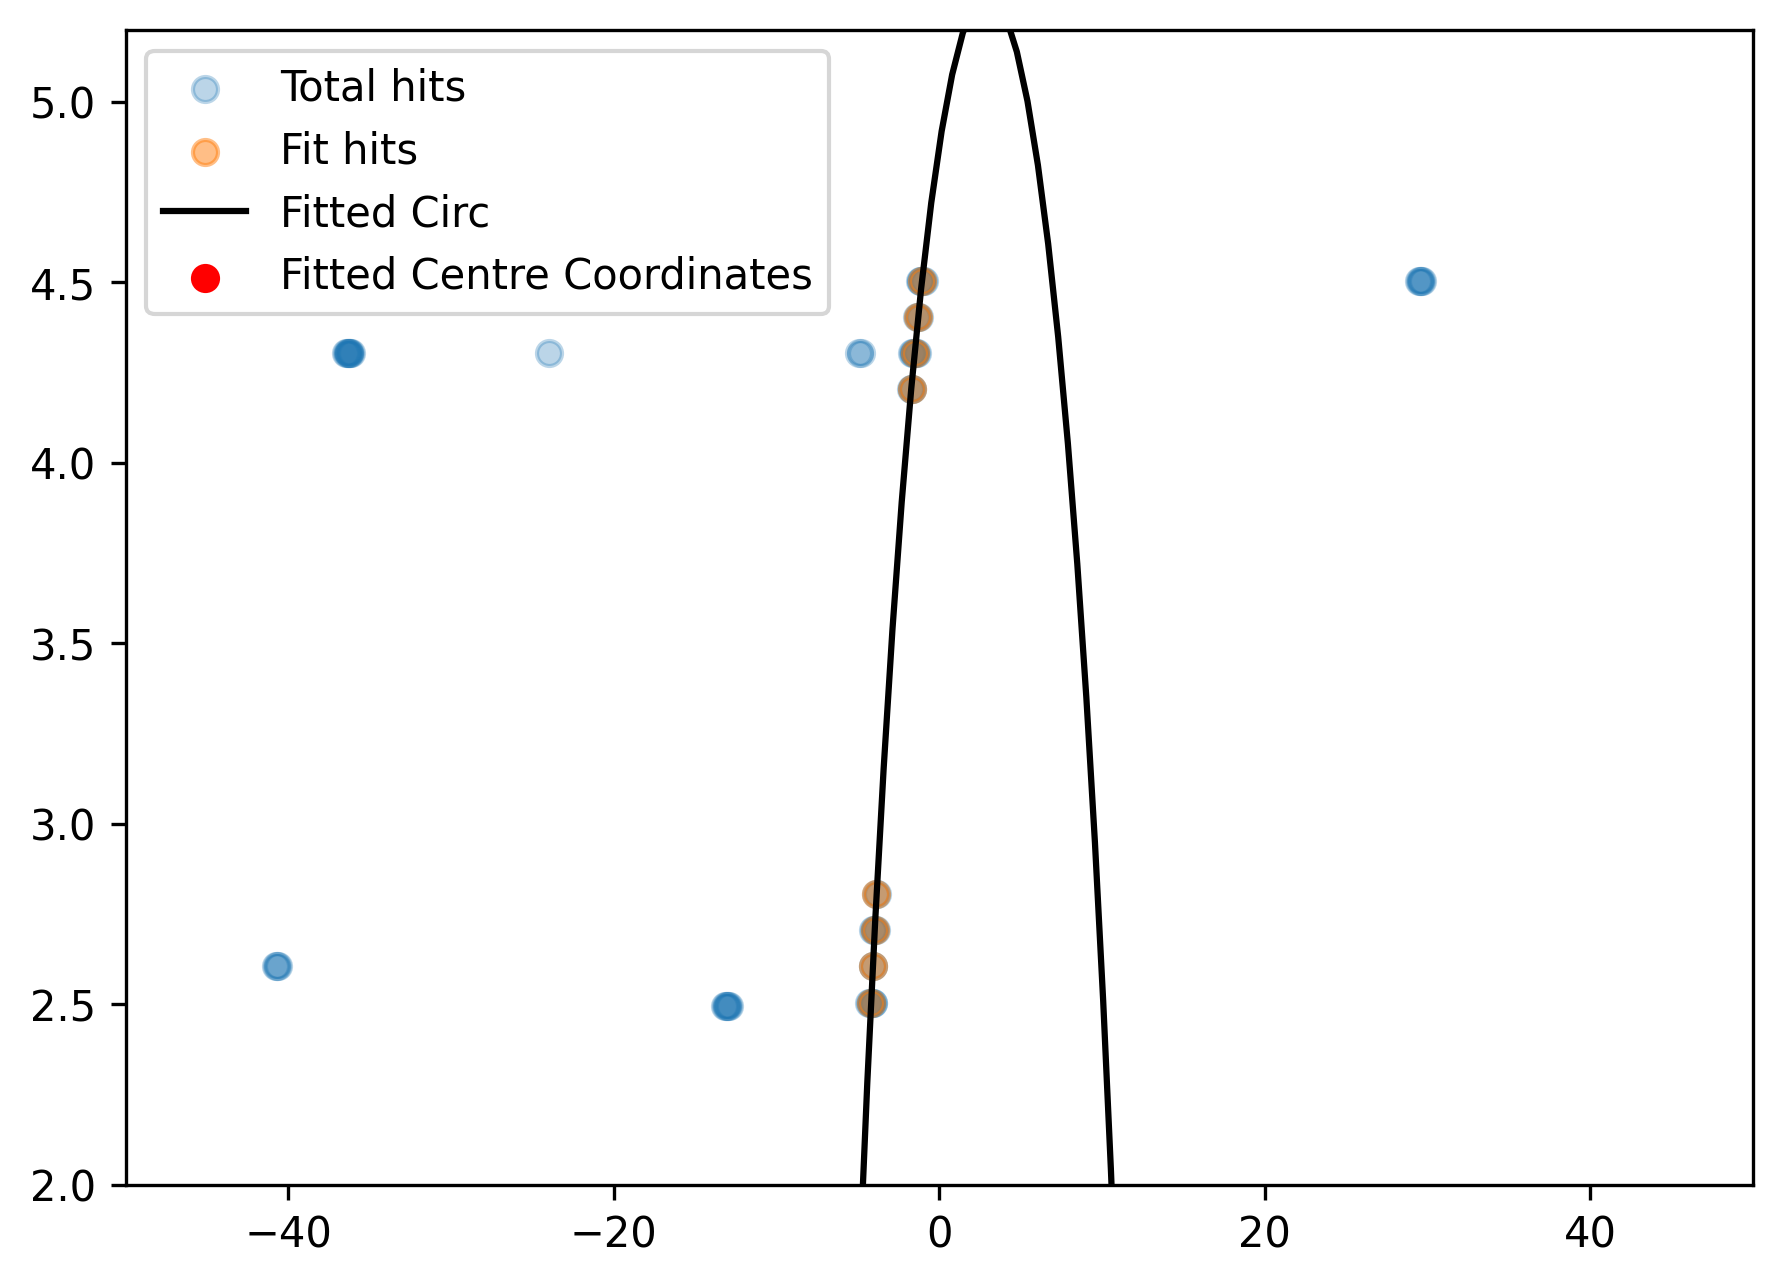

In [51]:
import matplotlib.pyplot as plt
import jaxopt
from jaxopt import ScipyMinimize

from jax.config import config
config.update("jax_enable_x64", True)


graph = GetGraphs(arrays_training, batch_size)[0]
graph_truth = GetGraphs(arrays_training,batch_size)[1]

network = hk.without_apply_rng(hk.transform(hk.vmap(gat_definition, split_rng=False)))
output_graph = network.apply(gnn_params, graph)

predictions = output_graph.nodes
coordinates = graph.nodes

def chisq_w_errors(par, x, y, w):
  y_error = 0.0005/jnp.sqrt(12)
  z_error = 0.1/jnp.sqrt(12)
  error = jnp.sqrt(y_error**2+z_error**2)
  
  residuals = func(par, x, y)
  chisq = (residuals**2/error)
  total_chisq = jnp.sum(w*chisq)
  weighted_residuals = w*(residuals**2)
  total_weight = jnp.sum(error**2)

  weighted_residuals_sum = jnp.sum(weighted_residuals)
  N = jnp.count_nonzero(w)
  return total_chisq
  #return weighted_residuals_sum /(N*total_weight)

def cluster_hits(input_graph, output_graph):
    coordinates = input_graph.nodes
    predictions = output_graph.nodes
    y_input = coordinates[:,:,0].ravel()
    z_input = coordinates[:,:,1].ravel()
    weights = predictions.ravel()
    weights = jnp.absolute(weights)
    weights = jnp.where(weights > 0.5, weights, 0)  
    layers = [2.495 , 2.505, 2.605, 2.705, 2.805, 4.205 , 4.305 ,4.405, 4.505]
    clustered_y = []
    for i in range(len(layers)):
      y = jnp.where(jnp.logical_and(z_input==layers[i],weights> 0.8) , y_input, 0)      
      y_mean = jnp.sum(y) / jnp.count_nonzero(y)
      clustered_y.append(y_mean)
    return clustered_y, layers

ycl, zcl = cluster_hits(graph, output_graph)

plt.scatter(graph.nodes[:,:,0], graph.nodes[:,:,1], color = 'blue', label = 'Initial hits', alpha = 0.3)
plt.scatter(ycl, zcl, color = 'red', label = 'Clustered hits', alpha = 0.3)
plt.legend()
plt.xlim(-2, 0)
plt.ylim(4.25, 4.50)
plt.show()
  
cluster_hits(graph, output_graph)

def get_fit_params(input_graph, output_graph):
    coordinates = input_graph.nodes
    
    y_input = coordinates[:,:,0].ravel()
    z_input = coordinates[:,:,1].ravel()
  
    y_cluster , z_cluster = jnp.array(cluster_hits(input_graph, output_graph))
 
    y_fit = jnp.nan_to_num(y_cluster)
    z_fit = jnp.where(y_fit != 0, z_cluster, 0)
    nan_label = jnp.ones(y_fit.shape)
    nan_label = jnp.where(y_fit != 0, nan_label, 0) 
  
    start = time.time()
    minimizer = jaxopt.BFGS(fun=chisq_w_errors)
    result = minimizer.run(jnp.array([1e-3, 0., 0.]), y_fit, z_fit, nan_label)
    #result = minimize(chisq_w_errors, jnp.array([1e-5,0.,0.]), args = (y_fit, z_fit, nan_label), method = 'BFGS')
    #print(result[0][0], result[0][1], result[0][2])
    end = time.time()
    print('fit time: ', end-start)  

    #minimizer = ScipyMinimize(method ="BFGS", fun=chisq_w_errors, implicit_diff_solve=True)
    #result = minimizer.run(jnp.array([0., 0., 0.]), y_fit, z_fit, nan_label)
    fitted_xcenter, fitted_ycenter, fitted_radius = final_params(result[0])
    print(fitted_xcenter, fitted_ycenter, fitted_radius)

 
    xc, yc = plot_circle(fitted_xcenter, fitted_ycenter, fitted_radius)

    plt.figure(figsize=(7, 5), dpi=300)
    plt.scatter(y_input, z_input, alpha = 0.3, label = 'Total hits')
    plt.scatter(y_fit, z_fit,alpha = 0.5, label = 'Fit hits' )
    plt.plot(xc, yc, color = 'black', label = 'Fitted Circ')
    plt.scatter(fitted_xcenter, fitted_ycenter, color = 'red', label = 'Fitted Centre Coordinates')
    plt.legend()
    plt.xlim(-50, 50)
    plt.ylim(2, 5.2)
    plt.show()

import time

get_fit_params(graph, output_graph)



fit time:  3.601818323135376
2.9418922969484895 -5.204164375480208 10.502805305404758


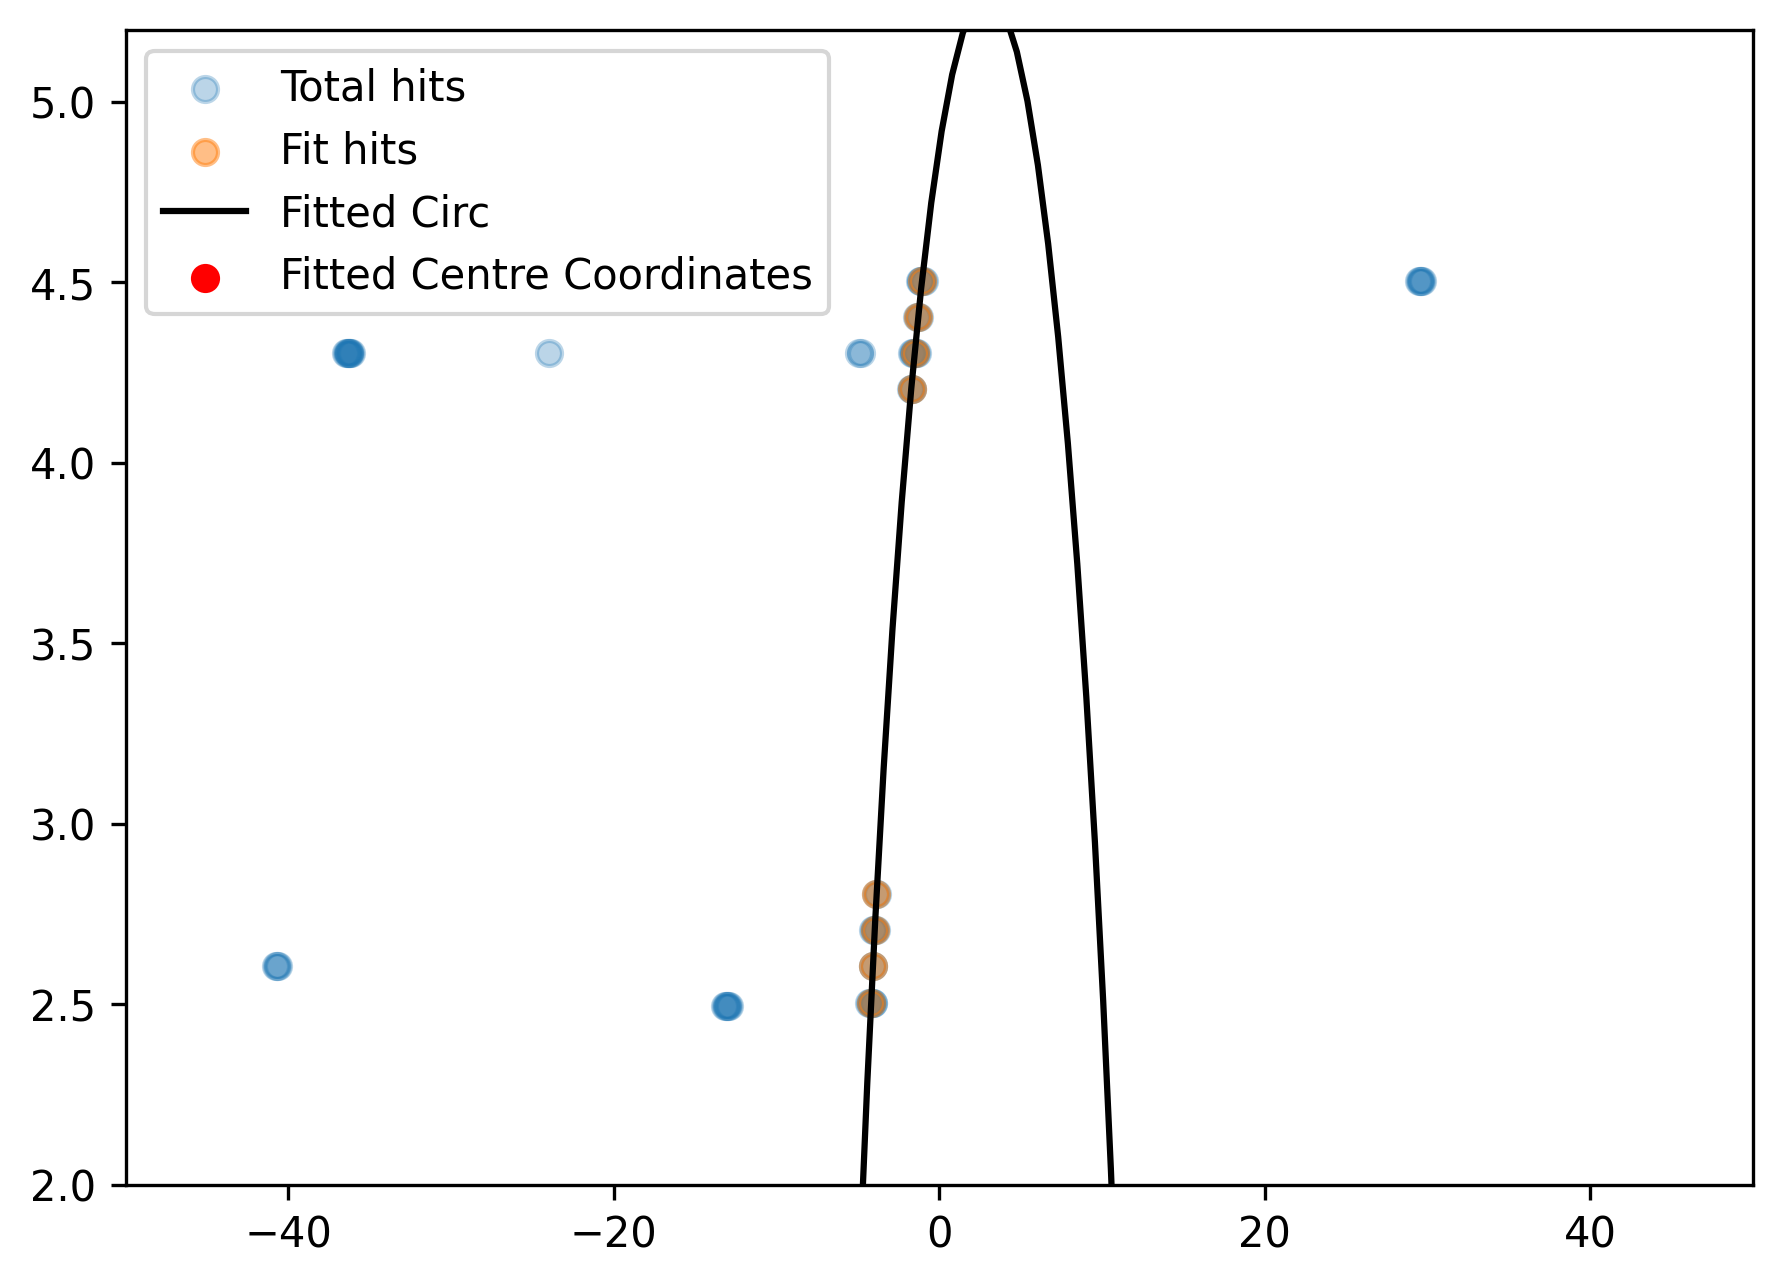

In [52]:

get_fit_params(graph, graph_truth)

In [53]:
import optax 
import itertools
lr = 1e-4
steps = 10

network = hk.without_apply_rng(hk.transform(hk.vmap(gat_definition, split_rng=False)))
params = network.init(jax.random.PRNGKey(1234), graph)
opt_init, opt_update = optax.adam(lr)
opt_state = opt_init(params)


@jax.jit
def update(params, opt_state, gr):
        """Returns updated params and state."""
        updates, opt_state = opt_update(gr, opt_state)
        return optax.apply_updates(params, updates), opt_state

def DataLoader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    #print('n_events: ', dataset_size, ', batch_size: ', batch_size)
        
    (key,) = jrandom.split(key, 1)
    start = 0
    end = batch_size
    while end <= dataset_size:
        
        yield tuple(GetGraphs(arrays[:,start:end], batch_size))
        start = end
        end = start + batch_size

@jax.jit
def prediction_loss(params, input_graph, target_graph):

        output_graph = network.apply(params, input_graph)        
        input_mask = input_graph.nodes[:,:,0]    
        radius = jnp.reshape(output_graph.nodes, (output_graph.nodes.shape[0], output_graph.nodes.shape[1]))
        
        id_mask = target_graph.nodes

        loss = (radius - id_mask)**2
        loss2 = jnp.where(input_mask != 5, loss, 0)   
        
        return jnp.sum(loss2) / jnp.count_nonzero(loss2)

dataloader = DataLoader(arrays_training, batch_size,  key = jrandom.PRNGKey(683))
it = itertools.tee(dataloader, steps)
gpus = jax.devices('gpu')


In [54]:
def cluster_hits(input_graph, output_graph):
    coordinates = input_graph.nodes
    predictions = output_graph.nodes
    y_input = coordinates[:,:,0].ravel()
    z_input = coordinates[:,:,1].ravel()
    weights = predictions.ravel()
    weights = jnp.absolute(weights)
    weights = jnp.where(weights > 0.5, weights, 0)  
    layers = [2.495 , 2.505, 2.605, 2.705, 2.805, 4.205 , 4.305 ,4.405, 4.505]
    clustered_y = []
    for i in range(len(layers)):
      y = jnp.where(jnp.logical_and(z_input==layers[i],weights> 0.8) , y_input, 0)      
      y_mean = jnp.sum(y) / jnp.count_nonzero(y)
      clustered_y.append(y_mean)
    return clustered_y, layers

@jax.jit
def get_fit_params(input_graph, output_graph):
    coordinates = input_graph.nodes
    
    y_input = coordinates[:,:,0].ravel()
    z_input = coordinates[:,:,1].ravel()
  
    y_cluster , z_cluster = jnp.array(cluster_hits(input_graph, output_graph))
 
    y_fit = jnp.nan_to_num(y_cluster)
    z_fit = jnp.where(y_fit != 0, z_cluster, 0)
    nan_label = jnp.ones(y_fit.shape)
    nan_label = jnp.where(y_fit != 0, nan_label, 0) 
  
    start = time.time()
    minimizer = jaxopt.BFGS(fun=chisq_w_errors)
    result = minimizer.run(jnp.array([1e-3, 0., 0.]), y_fit, z_fit, nan_label)
    end = time.time()
    print('fit time: ', end-start)  

    fitted_xcenter, fitted_ycenter, fitted_radius = final_params(result[0])
    print(fitted_xcenter, fitted_ycenter, fitted_radius)
    return fitted_xcenter, fitted_ycenter, fitted_radius


@jax.jit
def fit_loss(params, input_graph, truth_graph):
   output_graph = network.apply(params, input_graph)
   xp, yp, Rp = get_fit_params(input_graph, output_graph)
   xt, yt, Rt = get_fit_params(input_graph, truth_graph)
   print(1/3*((xp-xt)**2 + (yp-yt)**2 + (Rp-Rt)**2))
   return 1/3*((xp-xt)**2 + (yp-yt)**2 + (Rp-Rt)**2)


In [55]:
loss_list = []

for step in range(steps):
       
        epoch_loss = 0
        epoch_loss_fit = 0
        iter_data = it[step]
        for g in iter_data:
                input_graph = g[0]
                truth_graph = g[1]
               
                loss = prediction_loss(params, input_graph, truth_graph)        
                gr = jax.grad(prediction_loss, argnums=0)(params, input_graph, truth_graph)
                epoch_loss = loss               
                params, opt_state = update(params, opt_state, gr)

                output_graph = network.apply(params, input_graph)
                x_pred, y_pred, R_pred  = get_fit_params(input_graph, output_graph)
                x_truth, y_truth, R_truth = get_fit_params(input_graph, truth_graph)
                
                fit_loss = fit_loss(params, input_graph, truth_graph)
                gr_fit = jax.grad(fit_loss, argnums=0)(params, input_graph, truth_graph)
                params, opt_state = update(params, opt_state, gr_fit)
                epoch_loss_fit = fit_loss

        print('--------------------->  STEP: ', step, ' LOSS: ', epoch_loss, ' FIT LOSS: ', epoch_loss_fit)
        loss_list.append(epoch_loss)

fit time:  0.4064328670501709
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>
fit time:  0.4007687568664551
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


TypeError: Expected a callable value, got 164195.04465598695